# Introduction

This notebook explores an addition to the model free detection method.  Model free detection struggled during extended times of low irradiance.  This addition will filter periods of low irradiance based on the zscore.  For this method, a user must submit a number of days at a time so that zscoring can occur (here we use two weeks - it is unwise to use a very large time frame since seasonal affects may come affect filtering).

# Imports, configs, etc

In [1]:
import numpy as np
import pandas as pd
import datetime
import pvlib
import clearsky_detect_model_free
import preprocess

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()

import os, sys
lib_path = os.path.abspath(os.path.join('..', 'rdtools'))
sys.path.append(lib_path)
import filtering

import warnings

%load_ext autoreload
%autoreload 2

Loading BokehJS ...

# Setup

## Load data

Weather and performance data are taken at 1min intervals.  Supplier is the Sandia National Lab Regional Test Center in Albuquerque, NM.  Data spans roughly 2016-April 2017.  This data was scraped from PVDAQ (http://bit.ly/2mKrOwG).  The meteorological data and the performance data are contained in two separate files (technically separate systems - PV system and meteorological station).

In [48]:
def load_snl():
    filename = os.path.expanduser('~/data_sets/snl_raw_data/1429_1405/raw_1405_weather_for_1429.csv')
    cols = ['Global_Wm2', 'Date-Time']
    data = pd.read_csv(filename, parse_dates=['Date-Time'], usecols=cols, index_col=['Date-Time'])
    data.index = data.index.tz_localize('Etc/GMT+7')
    data = data.reindex(pd.date_range(start=data.index[0], end=data.index[-1], freq='1min')).fillna(0)
    data = pd.Series(data['Global_Wm2'], index=data.index)
    data[data < 0] = 0 
    return data

In [49]:
def load_srrl():
    srrl_file = os.path.expanduser('~/data_sets/srrl/20140101.csv')
    srrl_data = pd.read_csv(srrl_file)
    srrl_data.index = pd.to_datetime(srrl_data['DATE (MM/DD/YYYY)'] + ' ' + srrl_data['MST'])
    srrl_data.index = srrl_data.index.tz_localize('Etc/GMT+7')
    srrl_data = srrl_data[~srrl_data.index.duplicated(keep='first')]
    # srrl_data = srrl_data.reindex(
    #     pd.date_range(start=srrl_data.index[0], end=srrl_data.index[-1], freq='1min')
    # ).fillna(0)
    srrl_data.drop(['DATE (MM/DD/YYYY)', 'MST'], inplace=True, axis=1)
    srrl_data = pd.Series(srrl_data['Global 40-South LI-200 [W/m^2]'], index=srrl_data.index)
    srrl_data[srrl_data < 0] = 0
    srrl_data2 = pd.Series(0, index=pd.date_range(start=srrl_data.index.date[0], end=srrl_data.index.date[-1] + pd.Timedelta('1D'), freq='1min'))
    srrl_data2.index = srrl_data2.index.tz_localize('Etc/GMT+7')
    # print(srrl_data.index[0], srrl_data.index[-1])
    # print(srrl_data.index.date[0], srrl_data.index.date[-1])
    # print(srrl_data2.index[0], srrl_data2.index[-1])
    srrl_data2[srrl_data.index] = srrl_data
    srrl_data = srrl_data2.copy()
    return srrl_data

In [50]:
snl_data = load_snl()

## Set up PVLib systems

In [22]:
sample = snl_data[(snl_data.index >= '2016-07-01') & (snl_data.index < '2016-07-08')]

Series([], Freq: T, Name: Global_Wm2, dtype: float64)

In [35]:
p = figure(x_axis_type='datetime', tools=['tap', 'box_zoom', 'reset'])
p.line(sample.index, sample)
for day, group in sample.groupby(sample.index.day):
    group = group.between_time('11:30:00', '12:30:00')
    p.scatter(group.index, group, line_color='red', size=10)

In [36]:
show(p)

In [3]:
x = np.arange(0, 7, .1)
vals = np.sin(x)

<IPython.core.display.Javascript object>


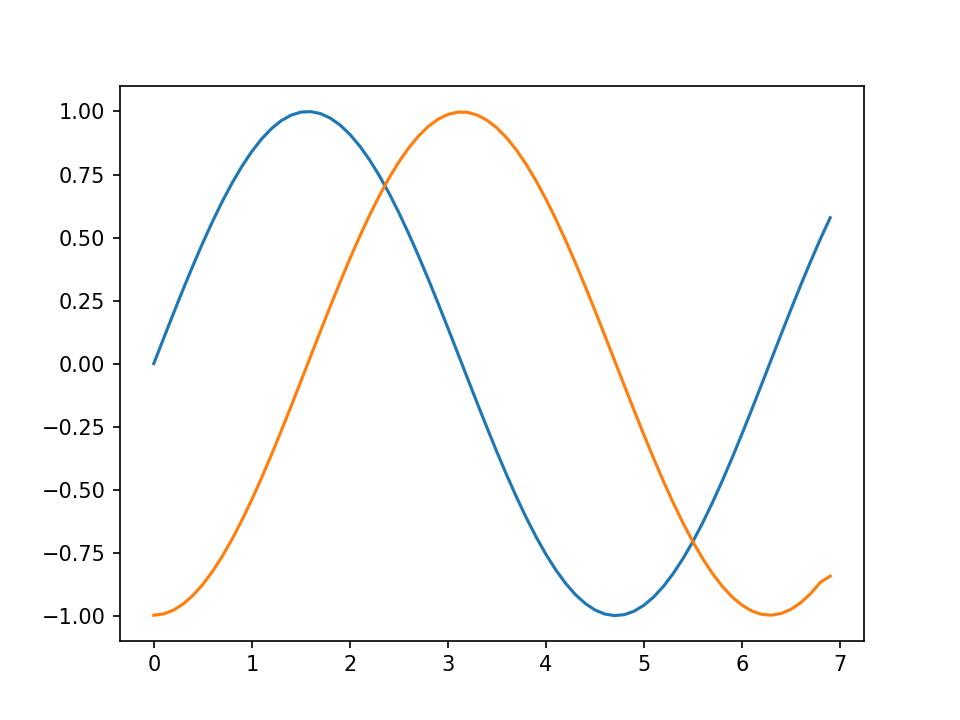

In [6]:
fig, ax = plt.subplots()

ax.plot(x, vals)
ax.plot(x, -np.gradient(vals, .1))